In [1]:
# this notebook is for figuring out how strong the length correlations of the RMs
# we're using are

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from rlhfutils.debug_utils import load_all_dfs, load_rm, progress_rm

/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-04 16:51:17,386] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import random
import torch

In [5]:
adfs = load_all_dfs("../outputs/lsanity/")

In [25]:
mpaths = [
    "../stack-llama/models/rmodel/",
    "/home/prasann/Projects/tfr-decoding/trlx_train/trl-stack/models/rewardda/",
    "/home/prasann/Projects/tfr-decoding/trlx_train/trl-stack/models/rewardmixed/",
    "/home/prasann/Projects/tfr-decoding/trlx_train/trl-stack/models/rewarddalen/"
]
toker, rm, kwargs = load_rm(mpaths[3], 2)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.76s/it]


In [7]:
respset = []
lenset = []
for a in adfs:
    respset.extend(list(adfs[a]['response']))
    lenset.extend([len(toker(ans).input_ids) for ans in adfs[a]['answer']])
flim = 0
responses = []
lens = []
origlens = []
for i in range(len(respset)):
    if lenset[i]>450:
        trunclen = random.randint(0, 400)
        responses.append(toker.decode(toker(respset[i]).input_ids[:-trunclen]))
        lens.append(lenset[i] - trunclen)
        origlens.append(lenset[i])

Token indices sequence length is longer than the specified maximum sequence length for this model (2320 > 2048). Running this sequence through the model will result in indexing errors


In [8]:
randinds = random.sample(list(range(len(responses))), 64)
lens = [lens[ind] for ind in randinds]
responses = [responses[ind] for ind in randinds]

(array([ 3.,  5.,  6.,  3.,  5.,  9.,  5.,  5.,  9., 14.]),
 array([ 89. , 130.9, 172.8, 214.7, 256.6, 298.5, 340.4, 382.3, 424.2,
        466.1, 508. ]),
 <BarContainer object of 10 artists>)

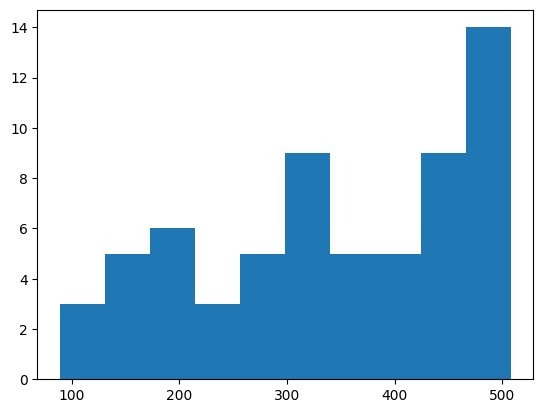

In [9]:
plt.hist(lens)

In [10]:
torch.cuda.empty_cache()

In [26]:
scos = progress_rm(responses, rm, kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:28<00:00, 22.08s/it]


In [22]:
scos = [s[0]['score'] for s in scos]

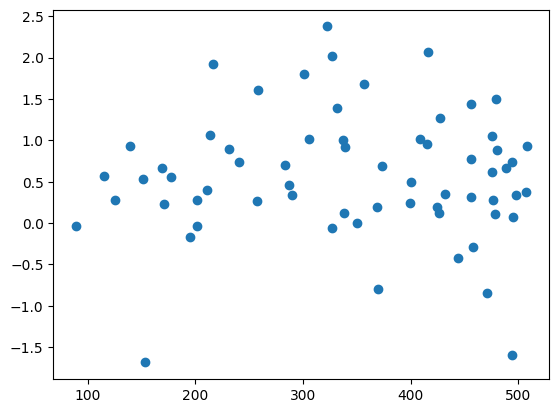

In [23]:
plt.scatter(lens, scos)

In [24]:
print(spearmanr(scos, lens))
print(pearsonr(scos, lens))


SignificanceResult(statistic=-0.012913270500166784, pvalue=0.9193327423893256)
PearsonRResult(statistic=-0.004704263036118053, pvalue=0.9705706757600637)


In [6]:
# check apfarm issue in a bit of detail